In [12]:
from pprint import pprint
import google.cloud.bigquery as bq
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi']= 360

In [3]:
%matplotlib inline
%load_ext google.cloud.bigquery

Extract hurricane observation records for :
* The North Atlantic basin
* Where there is available wind speed measurement
* After 1966 (the first satellite observation of a huricane)

Find the max classification of each hurricane by the [Saffir Simpson](https://en.wikipedia.org/wiki/Saffir%E2%80%93Simpson_scale) scale.

In [4]:
%%bigquery hrcn

SELECT
  CAST(season AS INT64) AS season_int,
  sid,
  max(USA_SSHS) category
FROM
  `bigquery-public-data.noaa_hurricanes.hurricanes`
WHERE
  basin = "NA"
  AND USA_SSHS IS NOT NULL
  AND USA_SSHS >= 1
  AND CAST(season AS INT64) > 1966
GROUP BY
  season_int, sid

In [5]:
decade_bins = list(range(1850, 2030, 10))

hrcn['decade'] = pd.cut(x=hrcn.season_int, bins=decade_bins, labels=decade_bins[:-1]).astype(int)

In [6]:
hrcn_pivot_decade = pd.pivot_table(data=hrcn,
                                   index='decade',
                                   columns='category',
                                   values='sid',
                                   aggfunc='count',
                                   fill_value=0)

hrcn_pivot_year = pd.pivot_table(data=hrcn,
                                 index='season_int',
                                 columns='category',
                                 values='sid',
                                 aggfunc='count',
                                 fill_value=0)

Visualize the count of storms per decade. The year-on-year count of storms varies significantly and does not allow us to clearly see the trend in the number of hurricanes. Therefore we count the number of storms per category per decade.

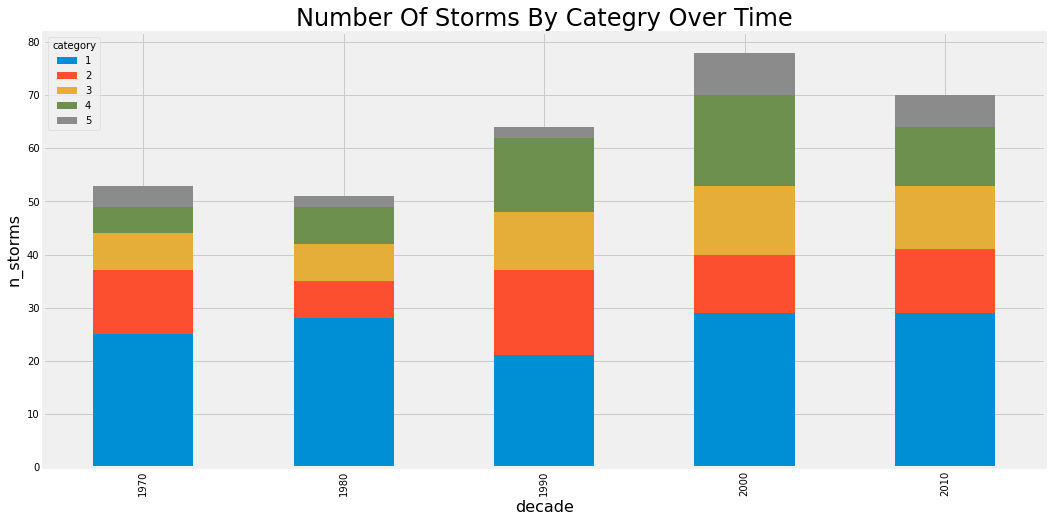

In [7]:
hrcn_pivot_decade.loc[1970:].plot.bar(stacked=True,figsize=(16, 8))

plt.title('Number Of Storms By Categry Over Time', size=24)
plt.ylabel('n_storms', size=16)
plt.xlabel('decade', size=16)
plt.show()

Quantify the trend of the number of storms per year. Fit a line through the points and measure the confidence and the slope.

In [10]:
hrcn_line_fits = {}
for c in hrcn_pivot_year.columns:
    slope, intercept, r_value, p_value, std_err = stats.linregress(hrcn_pivot_year.index, hrcn_pivot_year[c])
    fit_obj = {'slope': slope,
               'intercept': intercept,
               'r_value': r_value,
               'p_value': p_value,
               'std_err': std_err}
    hrcn_line_fits[c] = fit_obj

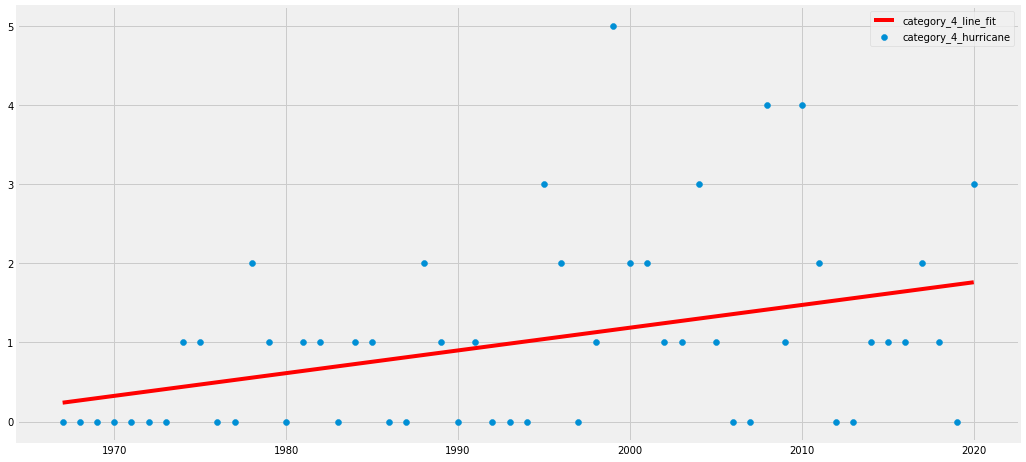

In [41]:
fig = plt.figure(figsize=(16, 8))

plt.scatter(hrcn_pivot_year.index,
            hrcn_pivot_year[4],
            label='category_4_hurricane')

plt.plot(hrcn_pivot_year.index,
         hrcn_line_fits[4]['intercept'] + hrcn_line_fits[4]['slope'] * hrcn_pivot_year.index,
         label='category_4_line_fit', c='r')

plt.legend()
plt.show()

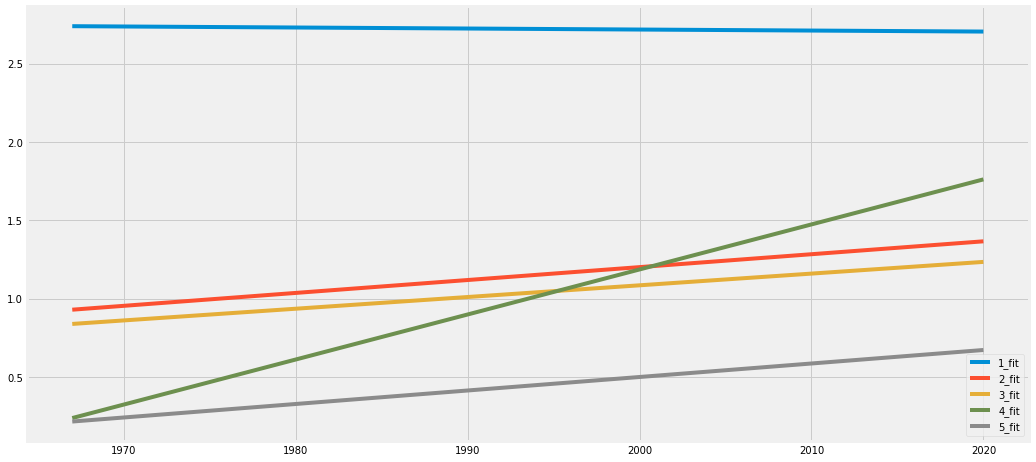

In [15]:
fig = plt.figure(figsize=(16, 8))

for c in hrcn_line_fits.keys():
    plt.plot(hrcn_pivot_year.index,
             hrcn_line_fits[c]['intercept'] + hrcn_line_fits[c]['slope'] * hrcn_pivot_year.index,
             label=str(c)+'_fit')

    plt.legend()
plt.show()